# DBSCAN and Hierarchical Clustering Analysis of Customer Shopping Trends

## 1.0 Business understanding

### 1.1 Business objective

### 1.2 Situational assessment

* Patterns and behaviors exhibited by customers are important to retailers.
* Analyzing purchasing pattern requires analysis of product categories, purchasing channels, and customer demographics.
* Analysing customer behavior requires purchase frequency, tranaction volume, and seasonality.
* Providing retail decision makers with insights from their customer data can create opportunities to respond to trends in purchasing patterns and behavior.

**Research Question #1:**
Are there distinct clusters of shopping trends?

**Hypothesis Couplet**

Null Hypothesis (H<sub>0</sub>): There are no differentiated clusters of shopping trends.


Alternate Hypothesis (H<sub>1</sub>): There are differentiated clusters of shopping trends.


## 2.0 Data Understanding

### 2.1 Prelimary data analysis

#### 2.1.1 Data mining goals

#### 2.1.2 Import libraries

In [262]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import numpy as np
import seaborn as sns
import itertools
import graphviz
import warnings

In [263]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score ,f1_score, silhouette_score, davies_bouldin_score
from sklearn.metrics import silhouette_score as ss
from sklearn.decomposition import PCA
from sklearn import decomposition
from IPython.display import clear_output
from mlxtend.plotting import plot_decision_regions
from google.colab import files
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, IsolationForest, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from xgboost import XGBClassifier

#### 2.1.3 Suppress warnings

In [264]:
warnings.filterwarnings('ignore')

#### 2.1.4 Data ingestion

In [265]:
# Import dataset
#create 2-dimensional dataFrames from a imported data.
#Choose the local file (baseball.csv).
#NOTE: YOU WILL NEED TO ALLOW THIRD-PARTY COOKIES FROM THIS SITE colab.research.google.com
from google.colab import files
uploaded = files.upload()

Saving shopping_trends.csv to shopping_trends (4).csv


In [266]:
file_name = "shopping_trends.csv"

In [267]:
# Load dataset
df=pd.read_csv(file_name)

In [268]:
pd.set_option('display.max_columns', None)
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


#### 2.1.5 Data description

**High Level Data Dictionary**

* Customer ID - Unique identifier for each customer
* Age - Age of the customer
* Gender - Gender of the customer (Male/Female)
* Item Purchased - The item purchased by the customer
* Category - Category of the item purchased
* Purchase Amount (USD) - The amount of the purchase in USD
* Location - Location where the purchase was made
* Size - Size of the purchased item
* Color - Color of the purchased item
* Season - Season during which the purchase was made
* Review Rating - Rating given by the customer for the purchased item
* Subscription Status - Indicates if the customer has a subscription (Yes/No)
* Shipping Type - Type of shipping chosen by the customer
* Discount Applied - Indicates if a discount was applied to the purchase (Yes/No)
* Promo Code Used - Indicates if a promo code was used for the purchase (Yes/No)
* Previous Purchases - The total count of transactions concluded by the customer at the store, excluding the ongoing transaction
* Payment Method - Customer's most preferred payment method
* Frequency of Purchases - Frequency at which the customer makes purchases (e.g., Weekly, Fortnightly, Monthly)

In [269]:
df.columns

Index(['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
       'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
       'Review Rating', 'Subscription Status', 'Payment Method',
       'Shipping Type', 'Discount Applied', 'Promo Code Used',
       'Previous Purchases', 'Preferred Payment Method',
       'Frequency of Purchases'],
      dtype='object')

In [270]:
df.describe()

,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,1950.500000,44.068462,59.764359,3.749949,25.351538
std,1125.977353,15.207589,23.685392,0.716223,14.447125
min,1.000000,18.000000,20.000000,2.500000,1.000000
25%,975.750000,31.000000,39.000000,3.100000,13.000000
50%,1950.500000,44.000000,60.000000,3.700000,25.000000
75%,2925.250000,57.000000,81.000000,4.400000,38.000000
max,3900.000000,70.000000,100.000000,5.000000,50.000000


In [271]:
df.describe(include='object')

,Gender,Item Purchased,Category,Location,Size,Color,Season,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Preferred Payment Method,Frequency of Purchases
count,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900
unique,2,25,4,50,4,25,4,2,6,6,2,2,6,7
top,Male,Blouse,Clothing,Montana,M,Olive,Spring,No,Credit Card,Free Shipping,No,No,PayPal,Every 3 Months
freq,2652,171,1737,96,1755,177,999,2847,696,675,2223,2223,677,584


### 2.2 Data quality

#### 2.2.1 Check for missing values

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 14  Discount

There are no missing values.

#### 2.2.2 Check for outliers

In [273]:
feature_df = df.select_dtypes(include='number')

In [274]:
rows, cols = 2, 3
num_columns = len(feature_df.columns)
num_plots = min(rows * cols, num_columns)

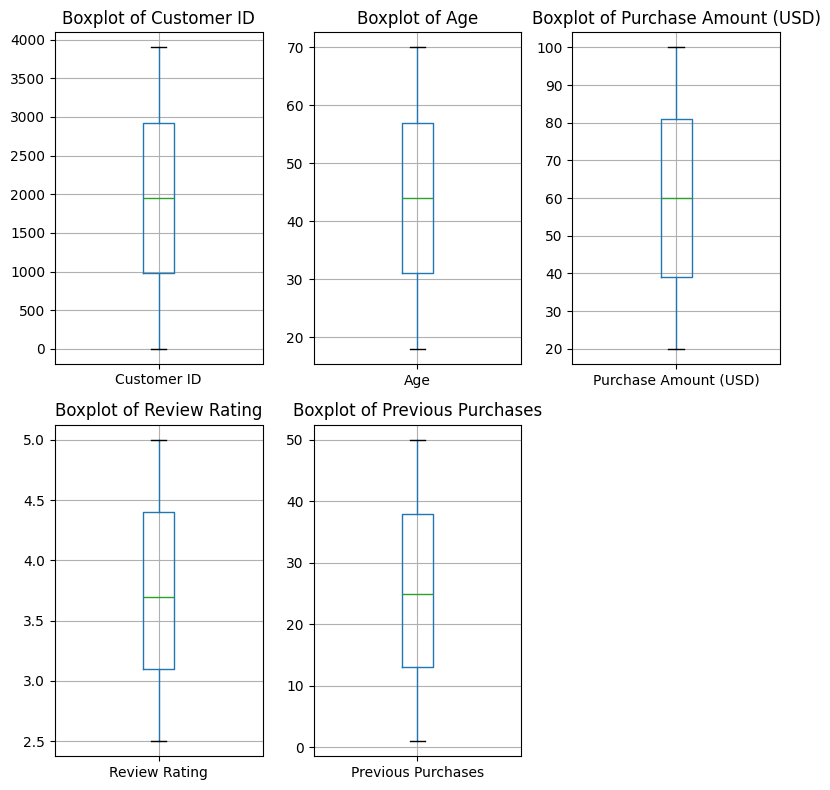

In [275]:
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
axes = axes.flatten()

for i, column in enumerate(feature_df.columns[:rows * cols]):
    feature_df.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

There are no outliers.

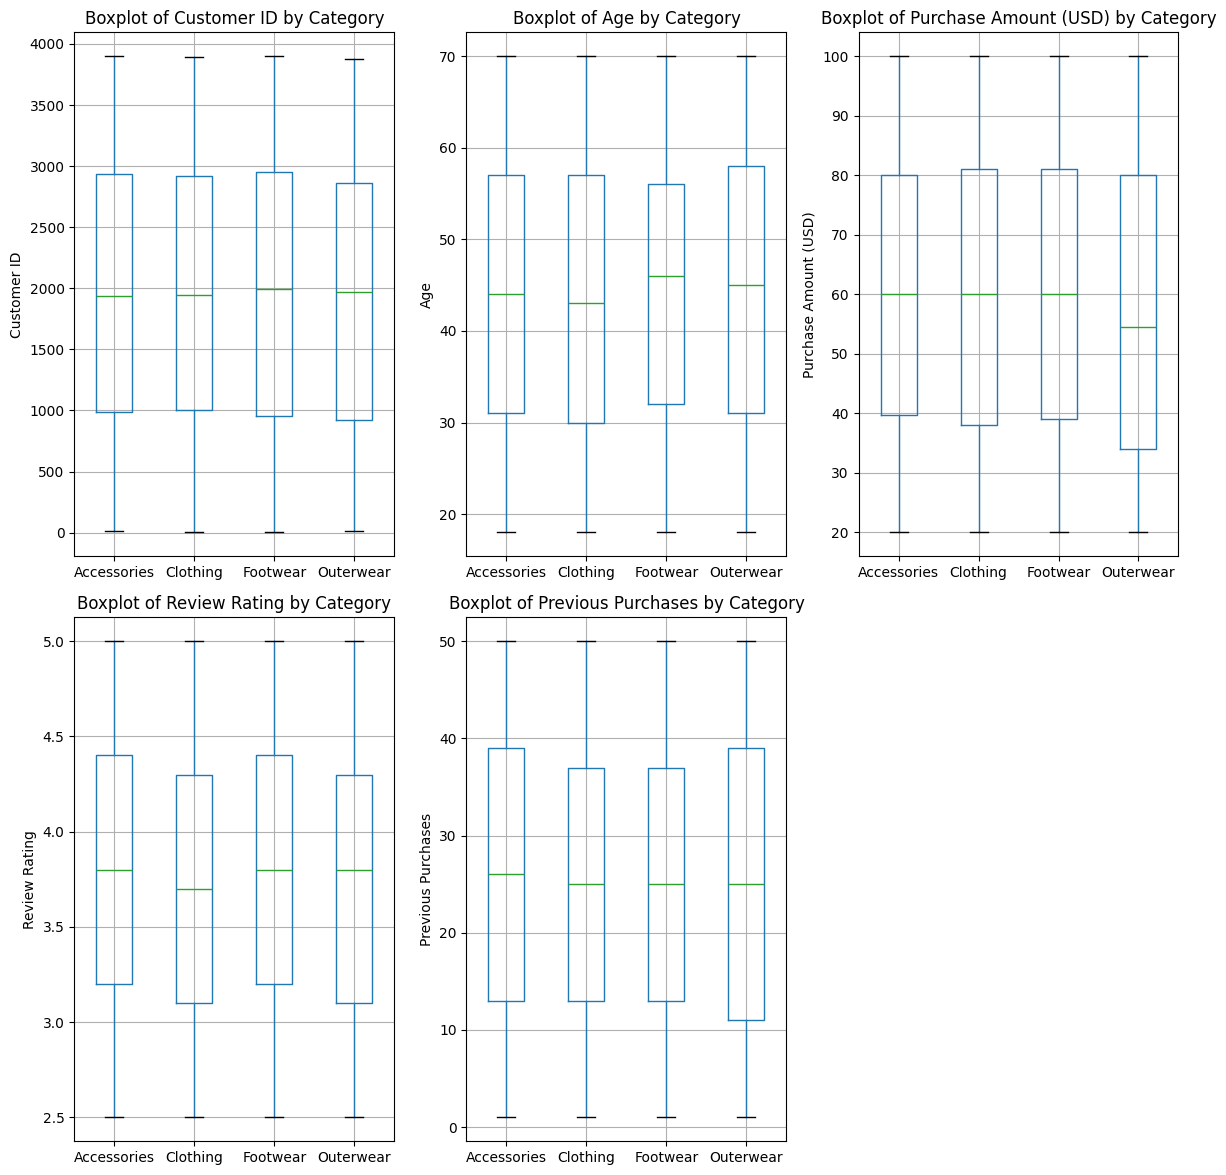

In [276]:
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
axes = axes.flatten()

for i, column in enumerate(feature_df.columns[:rows * cols]):
    df.boxplot(column=column, by='Category', ax=axes[i])
    axes[i].set_title(f'Boxplot of {column} by Category')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(column)

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

fig.suptitle('')
plt.tight_layout()
plt.show()

#### 2.2.3 Check for duplicates

In [277]:
df.duplicated().sum()

np.int64(0)

There are no duplicate rows.

### 2.3 Exploratory data analysis

#### 2.3.1 Check distributions of numeric variables

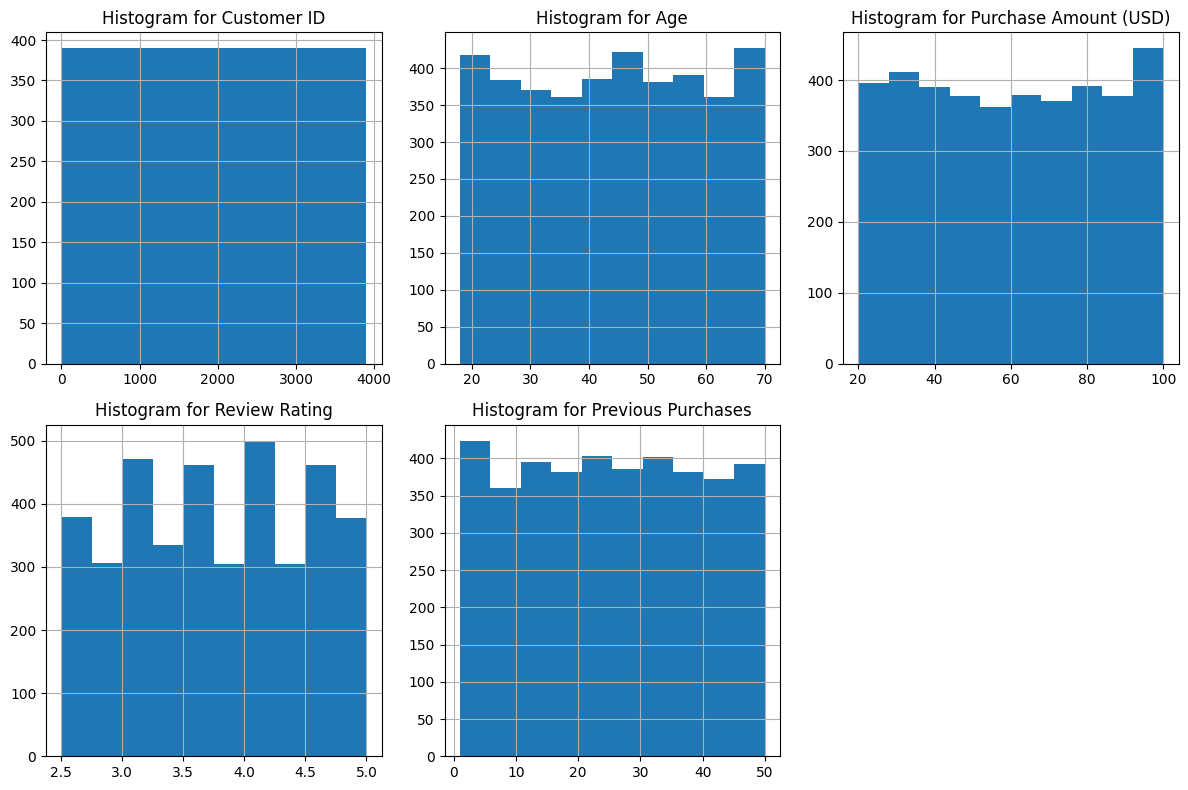

In [278]:
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()

# Select only numeric columns for histogram plotting
numeric_feature_df = feature_df.select_dtypes(include=np.number)
num_numeric_columns = len(numeric_feature_df.columns)
num_plots = min(rows * cols, num_numeric_columns)


for i, column in enumerate(numeric_feature_df.columns[:rows * cols]):
    numeric_feature_df.hist(column=column, ax=axes[i])
    axes[i].set_title(f'Histogram for {column}')

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 2.3.2 Check density of numeric variables

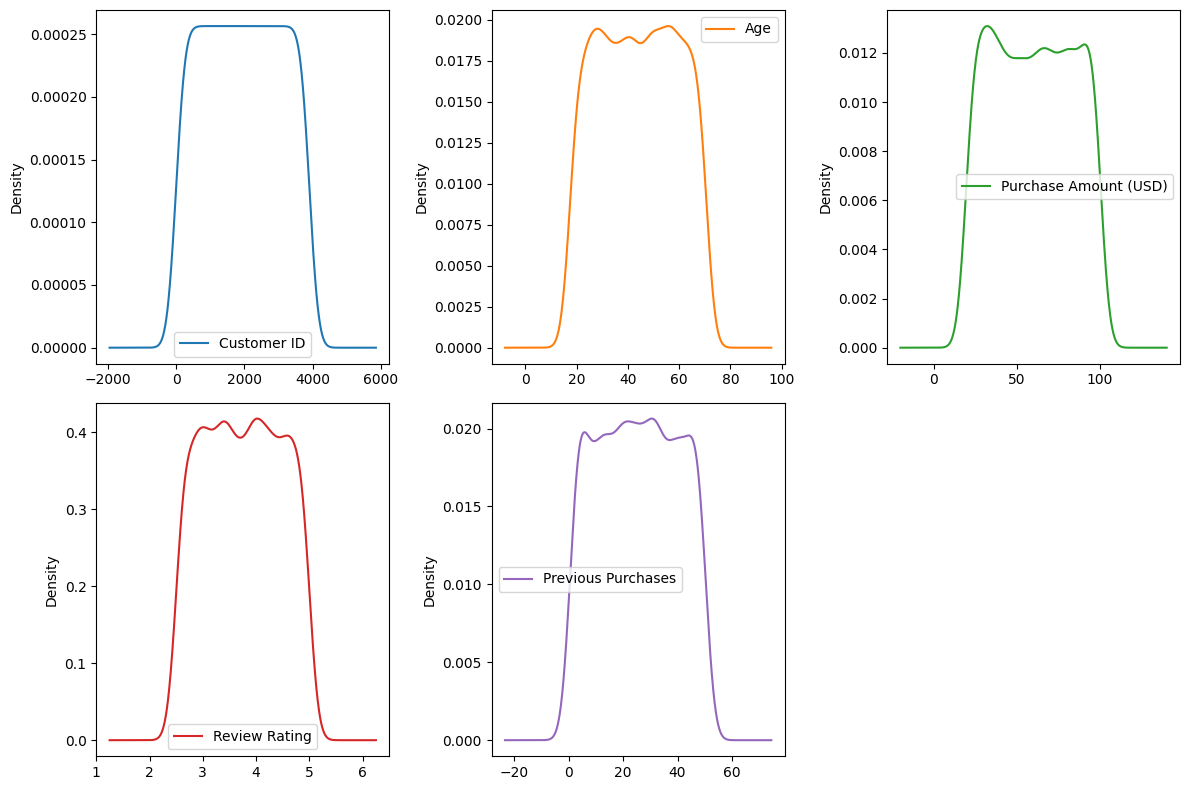

In [279]:
feature_df.plot(kind='density', subplots=True, layout=(2, 3), figsize=(12, 8), sharex=False)
plt.tight_layout()
plt.show()

#### 2.3.3 Check skewness of continuous numeric variables

In [280]:
numeric_feature_df.skew().to_frame().rename(columns={0:"Feature Skewness"})

,Feature Skewness
Customer ID,0.000000
Age,-0.006380
Purchase Amount (USD),0.012702
Review Rating,0.004525
Previous Purchases,0.003121


No numeric features are skewed.

#### 2.3.3 Check corrleations of numeric variables

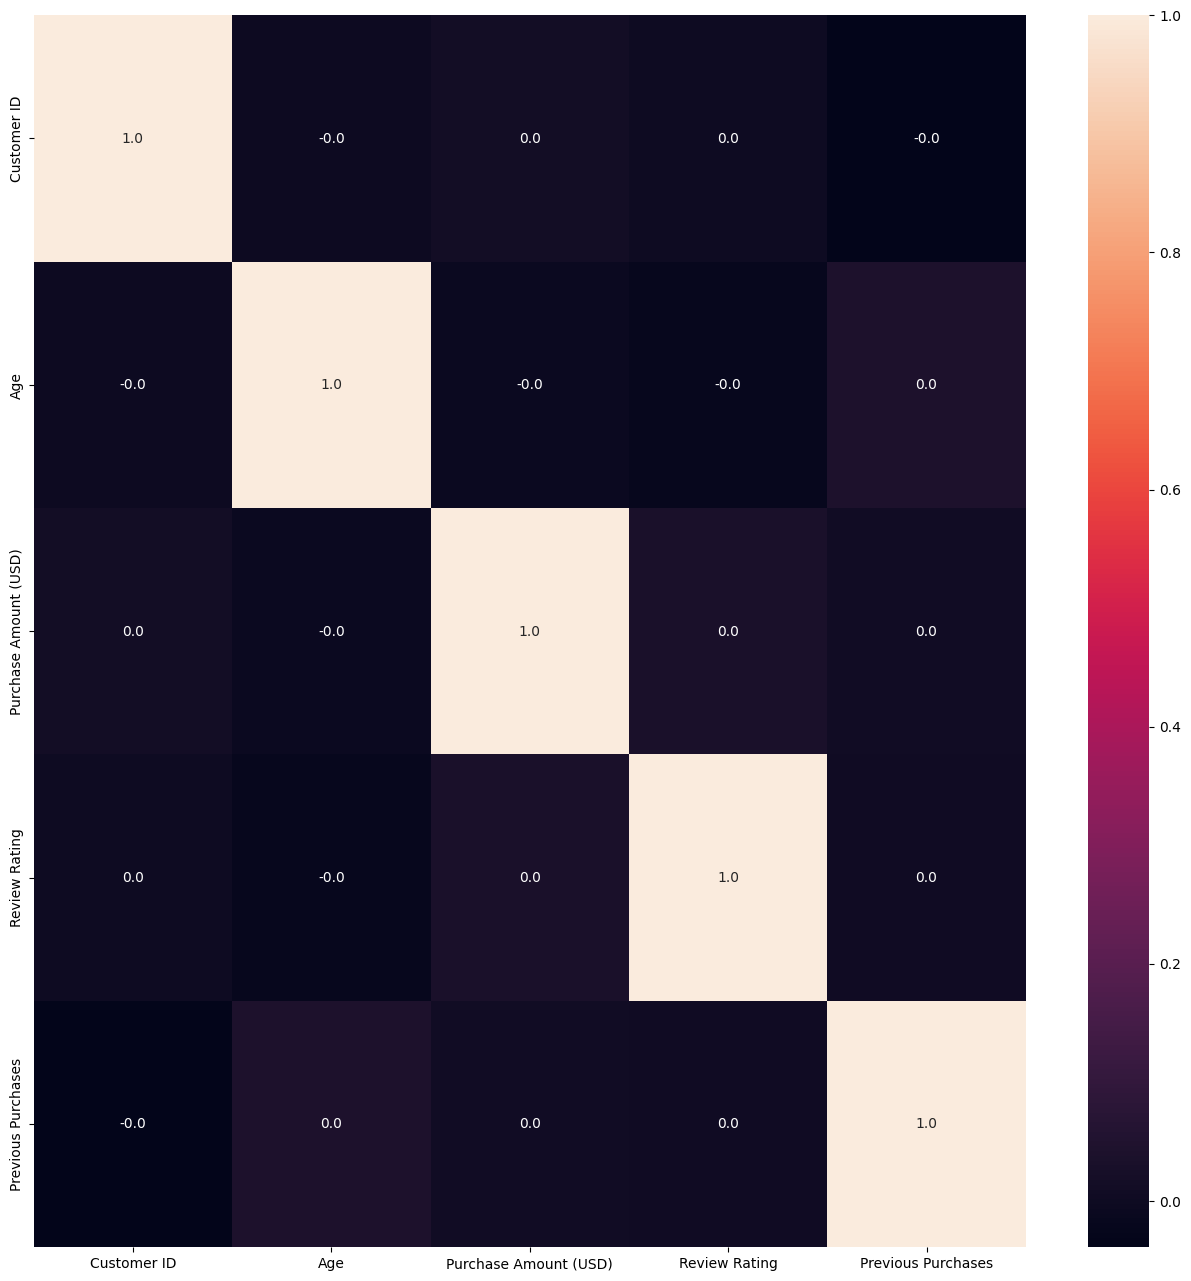

In [281]:
plt.figure(figsize=[16,16],facecolor='white')
sns.heatmap(feature_df.corr(), annot=True, fmt=".1f")
plt.show()

No numeric features are correlated.

#### 2.3.4 Number of customers by category for categorical features

In [282]:
def cust_purchase_cat(column):
  plt.figure(figsize=(12,6))
  ax = sns.countplot(x=column, hue='Category', data=df)
  for val in ax.containers:
    ax.bar_label(val)
  plt.title(f'Customers by Category for {column}')
  plt.show()

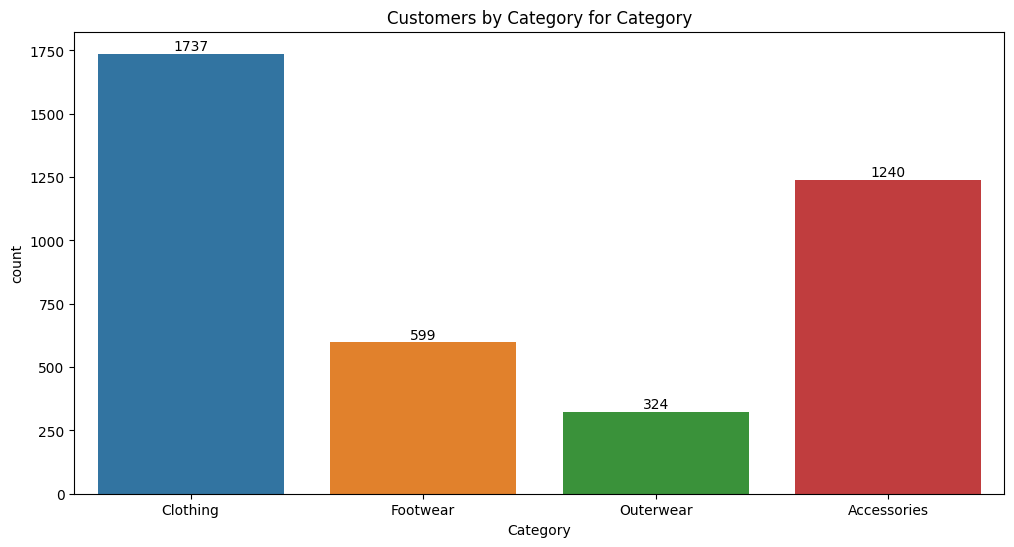

In [283]:
cust_purchase_cat('Category')

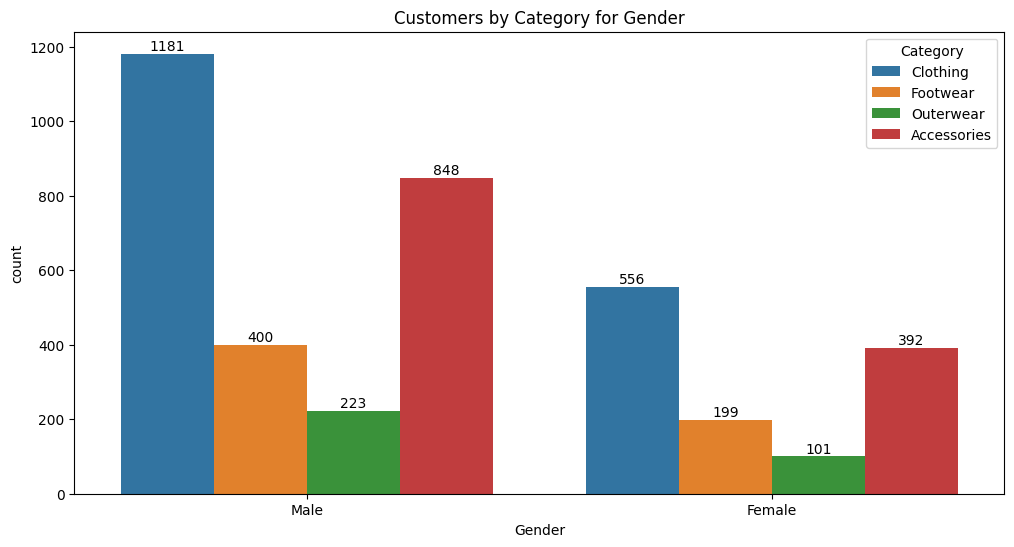

In [284]:
cust_purchase_cat('Gender')

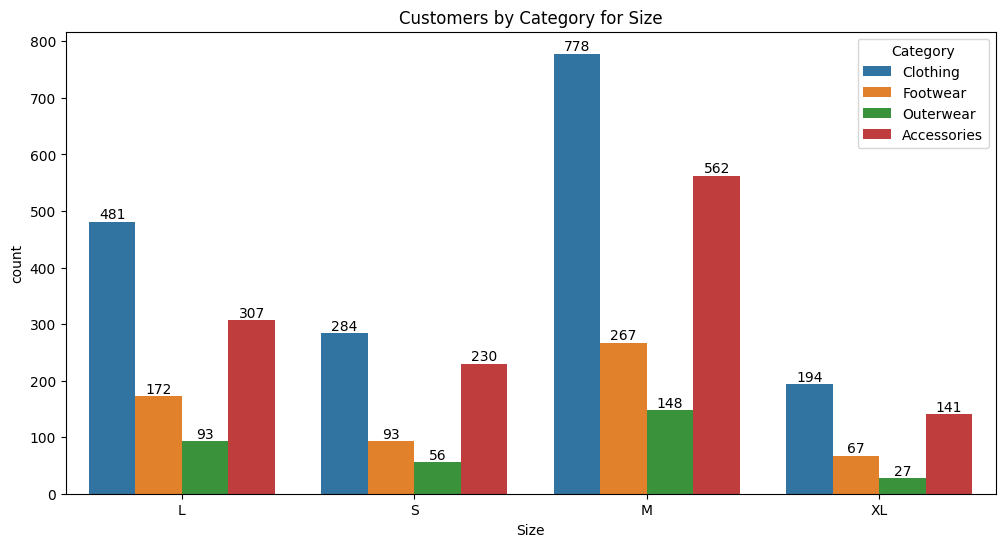

In [285]:
cust_purchase_cat('Size')

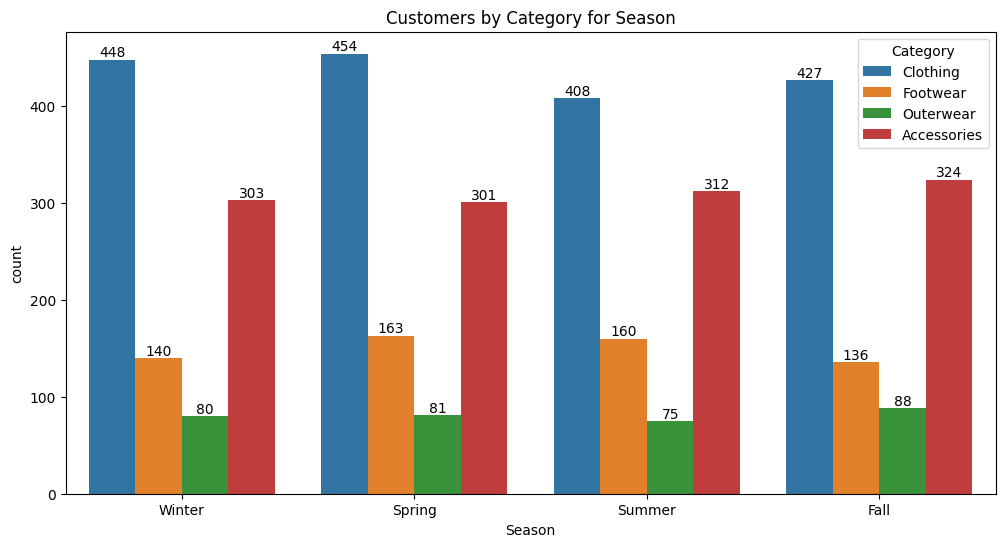

In [286]:
cust_purchase_cat('Season')

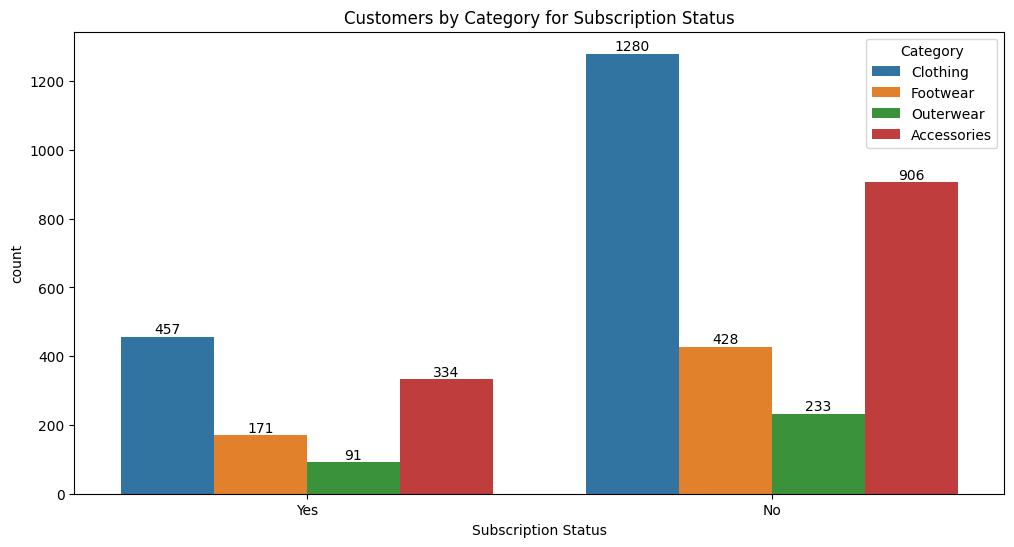

In [287]:
cust_purchase_cat('Subscription Status')

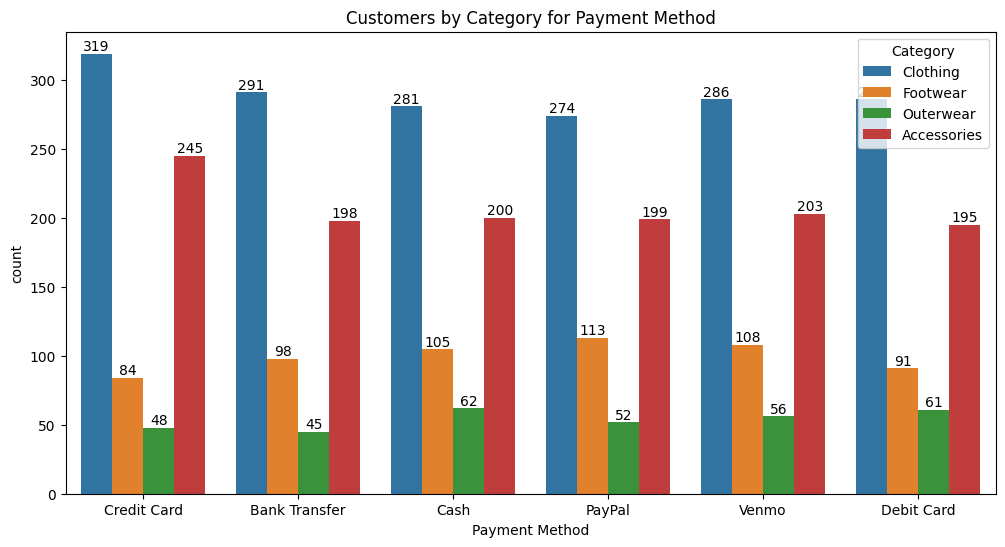

In [288]:
cust_purchase_cat('Payment Method')

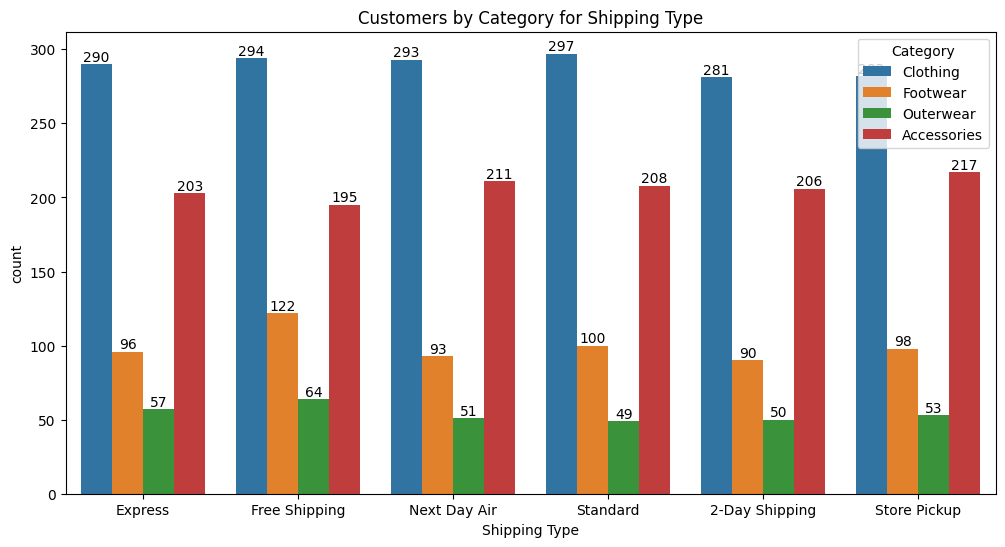

In [289]:
cust_purchase_cat('Shipping Type')

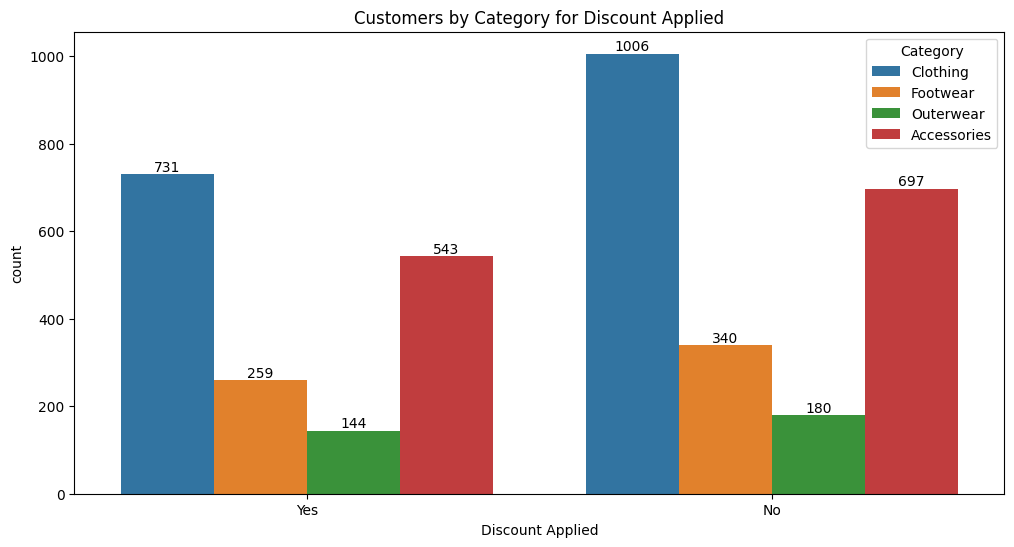

In [290]:
cust_purchase_cat('Discount Applied')

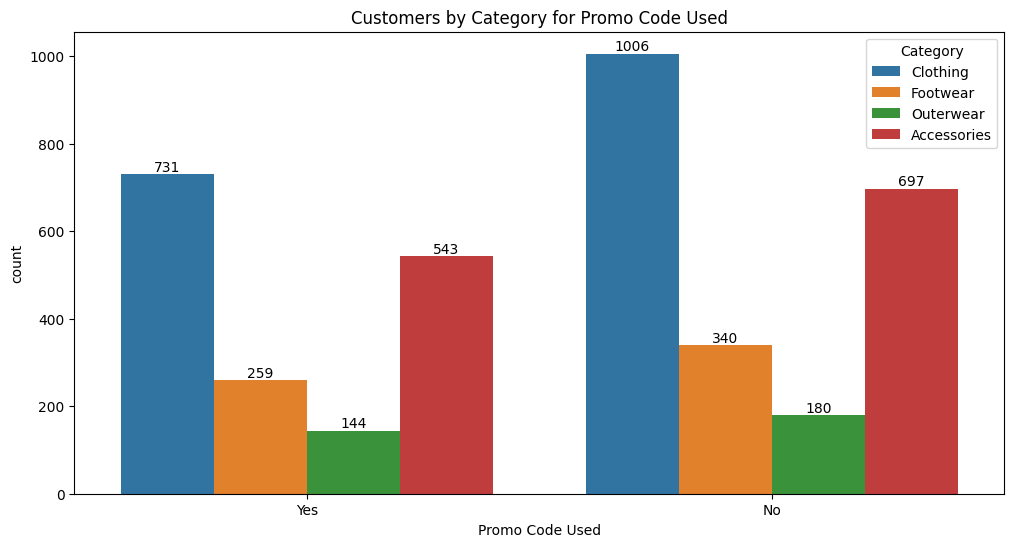

In [291]:
cust_purchase_cat('Promo Code Used')

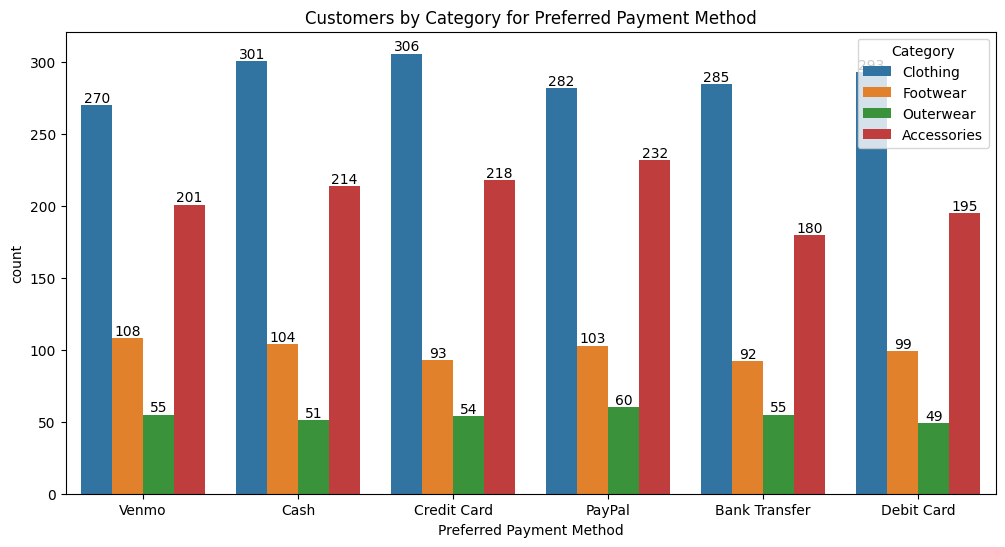

In [292]:
cust_purchase_cat('Preferred Payment Method')

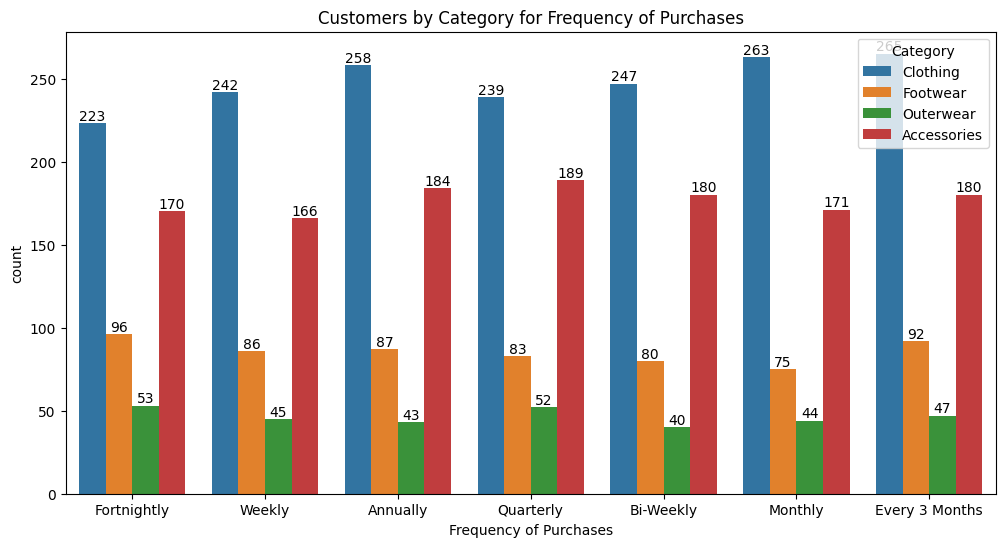

In [293]:
cust_purchase_cat('Frequency of Purchases')

#### 2.3.5 Number of customers by category for numeric features

In [294]:
def cust_purchase_num(column):
  plt.figure(figsize=(12,4))

  plt.subplot(1,2,1)
  sns.histplot(x=column, hue='Category', data=df)
  plt.title(f'Distribution of {column} by Category')

  plt.subplot(1,2,2)
  sns.boxplot(x='Category', y=column, data=df)
  plt.title(f'Distribution of {column} by Category')

  plt.tight_layout()
  plt.show()

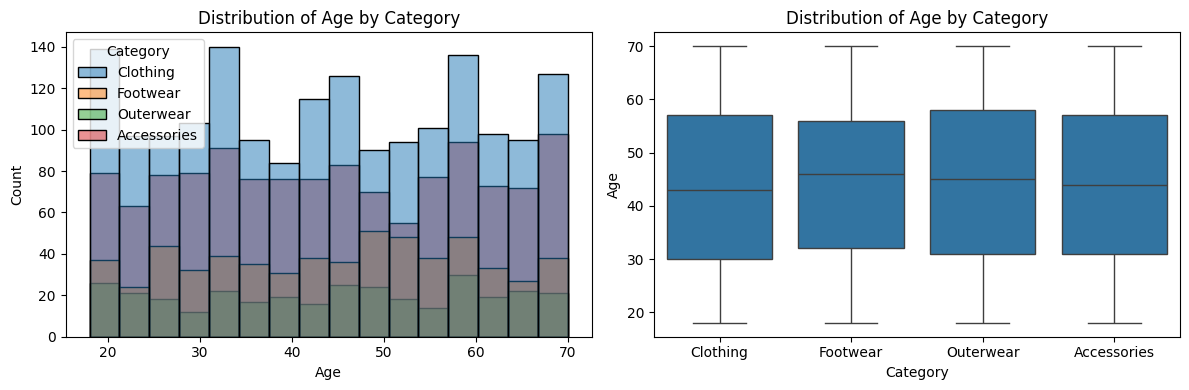

In [295]:
cust_purchase_num('Age')

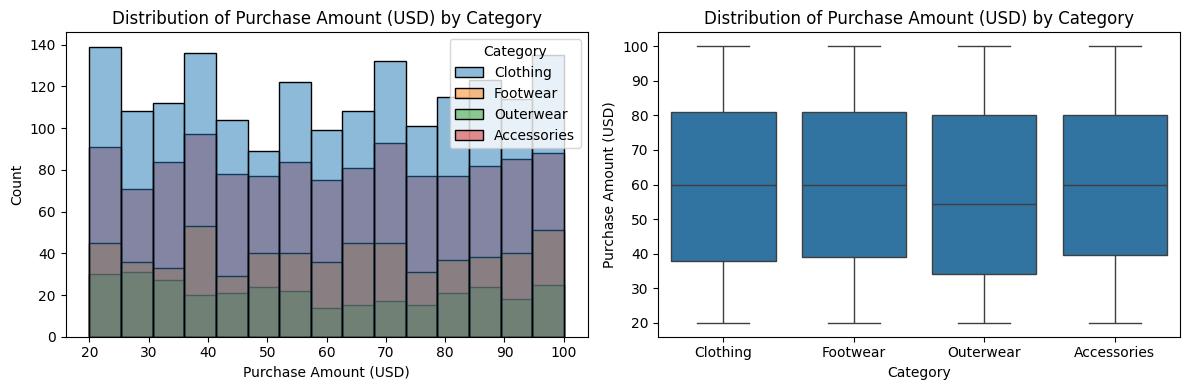

In [296]:
cust_purchase_num('Purchase Amount (USD)')

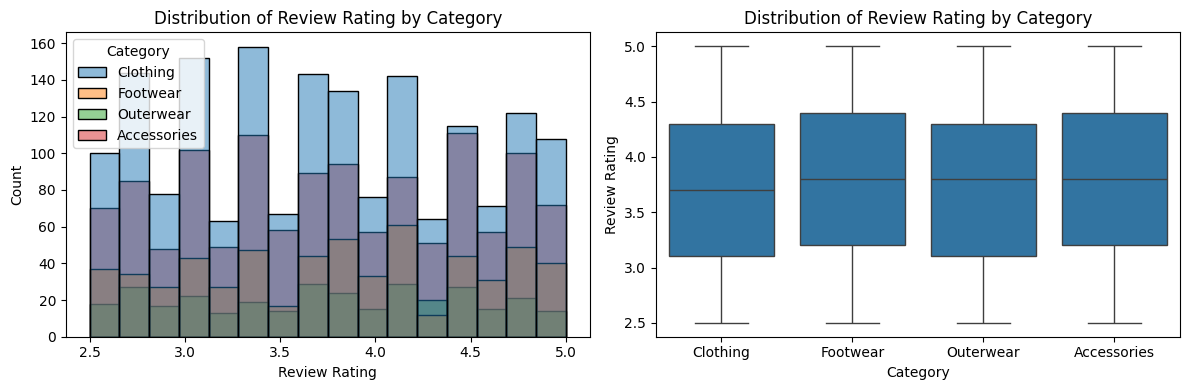

In [297]:
cust_purchase_num('Review Rating')

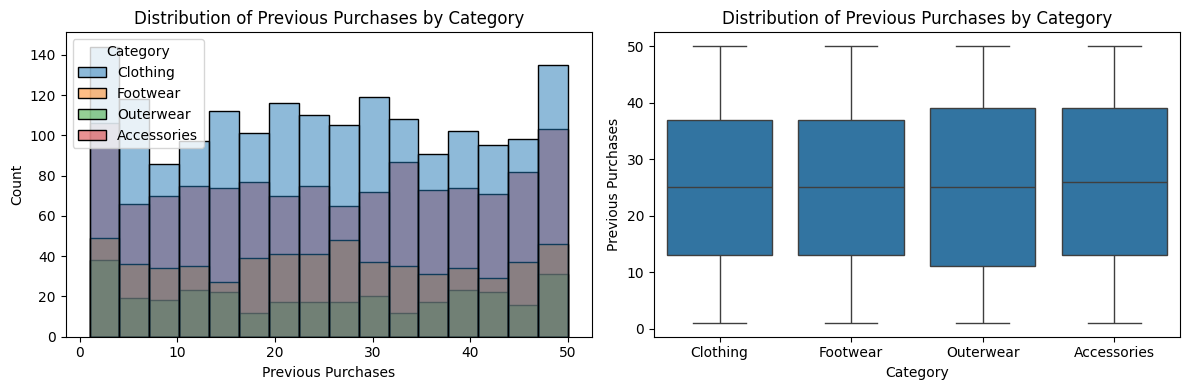

In [298]:
cust_purchase_num('Previous Purchases')

## 3.0 Data preprocessing

### 3.1 Data cleansing

#### 3.1.1 No missing values

#### 3.1.2 No duplicate rows

#### 3.1.3 No highly correlated features

#### 3.1.4 Remove unnecessary features

In [299]:
df.drop(columns=['Customer ID'],inplace=True)

### 3.2 Feature engineering

#### 3.2.1 Feature encoding

##### 3.2.1.1 One-hot encoding

In [300]:
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') #, drop='first'

In [301]:
onehot_encoding = ['Gender', 'Subscription Status', 'Discount Applied', 'Promo Code Used', 'Category']

In [302]:
encoded_df_list = []

In [303]:
for col in onehot_encoding:
    transformed = onehot_encoder.fit_transform(df[[col]])
    n_cols = transformed.shape[1]
    cats = onehot_encoder.categories_[0][-n_cols:]  # Take only the encoded categories
    feature_names = [f"{col}_{cat}" for cat in cats]
    encoded_df_list.append(pd.DataFrame(transformed, columns=feature_names, index=df.index))

In [304]:
df_encoded = pd.concat([df.drop(columns=onehot_encoding)] + encoded_df_list, axis=1)

In [305]:
df_encoded.head()

,Age,Item Purchased,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Payment Method,Shipping Type,Previous Purchases,Preferred Payment Method,Frequency of Purchases,Gender_Female,Gender_Male,Subscription Status_No,Subscription Status_Yes,Discount Applied_No,Discount Applied_Yes,Promo Code Used_No,Promo Code Used_Yes,Category_Accessories,Category_Clothing,Category_Footwear,Category_Outerwear
0,55,Blouse,53,Kentucky,L,Gray,Winter,3.1,Credit Card,Express,14,Venmo,Fortnightly,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,19,Sweater,64,Maine,L,Maroon,Winter,3.1,Bank Transfer,Express,2,Cash,Fortnightly,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,50,Jeans,73,Massachusetts,S,Maroon,Spring,3.1,Cash,Free Shipping,23,Credit Card,Weekly,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,21,Sandals,90,Rhode Island,M,Maroon,Spring,3.5,PayPal,Next Day Air,49,PayPal,Weekly,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,45,Blouse,49,Oregon,M,Turquoise,Spring,2.7,Cash,Free Shipping,31,PayPal,Annually,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


##### 3.2.1.2 Label encoding

In [306]:
label_encoder = LabelEncoder()

In [307]:
label_encoding = ['Size', 'Season', 'Frequency of Purchases']

In [308]:
for col in label_encoding:
    df_encoded[f'{col}_seq'] = label_encoder.fit_transform(df_encoded[col])

In [309]:
df_encoded = df_encoded.drop(columns=label_encoding)

In [310]:
df_encoded.head()

,Age,Item Purchased,Purchase Amount (USD),Location,Color,Review Rating,Payment Method,Shipping Type,Previous Purchases,Preferred Payment Method,Gender_Female,Gender_Male,Subscription Status_No,Subscription Status_Yes,Discount Applied_No,Discount Applied_Yes,Promo Code Used_No,Promo Code Used_Yes,Category_Accessories,Category_Clothing,Category_Footwear,Category_Outerwear,Size_seq,Season_seq,Frequency of Purchases_seq
0,55,Blouse,53,Kentucky,Gray,3.1,Credit Card,Express,14,Venmo,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,3,3
1,19,Sweater,64,Maine,Maroon,3.1,Bank Transfer,Express,2,Cash,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,3,3
2,50,Jeans,73,Massachusetts,Maroon,3.1,Cash,Free Shipping,23,Credit Card,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2,1,6
3,21,Sandals,90,Rhode Island,Maroon,3.5,PayPal,Next Day Air,49,PayPal,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,6
4,45,Blouse,49,Oregon,Turquoise,2.7,Cash,Free Shipping,31,PayPal,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1,1,0


##### 3.2.1.3 Frequcency encoding

In [311]:
frequency_encoding = ['Payment Method', 'Shipping Type', 'Preferred Payment Method', 'Item Purchased', 'Location', 'Color']

In [312]:
for col in frequency_encoding:
    freq = df_encoded[col].value_counts() / len(df_encoded)
    df_encoded[f'{col}_freq'] = df_encoded[col].map(freq)

In [313]:
df_encoded = df_encoded.drop(columns=frequency_encoding)

In [314]:
df_encoded.head()

,Age,Purchase Amount (USD),Review Rating,Previous Purchases,Gender_Female,Gender_Male,Subscription Status_No,Subscription Status_Yes,Discount Applied_No,Discount Applied_Yes,Promo Code Used_No,Promo Code Used_Yes,Category_Accessories,Category_Clothing,Category_Footwear,Category_Outerwear,Size_seq,Season_seq,Frequency of Purchases_seq,Payment Method_freq,Shipping Type_freq,Preferred Payment Method_freq,Item Purchased_freq,Location_freq,Color_freq
0,55,53,3.1,14,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,3,3,0.178462,0.165641,0.162564,0.043846,0.020256,0.040769
1,19,64,3.1,2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,3,3,0.162051,0.165641,0.171795,0.042051,0.019744,0.040513
2,50,73,3.1,23,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2,1,6,0.166154,0.173077,0.172051,0.031795,0.018462,0.040513
3,21,90,3.5,49,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,6,0.163590,0.166154,0.173590,0.041026,0.016154,0.040513
4,45,49,2.7,31,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1,1,0,0.166154,0.173077,0.173590,0.043846,0.018974,0.037179


### 3.3 Data Transformation

#### 3.3.1 Scale numeric variables

In [315]:
scaler = StandardScaler()

In [316]:
scaled_data = scaler.fit_transform(df_encoded)
df_scaled = pd.DataFrame(scaled_data, columns=df_encoded.columns)
df_scaled.describe()

,Age,Purchase Amount (USD),Review Rating,Previous Purchases,Gender_Female,Gender_Male,Subscription Status_No,Subscription Status_Yes,Discount Applied_No,Discount Applied_Yes,Promo Code Used_No,Promo Code Used_Yes,Category_Accessories,Category_Clothing,Category_Footwear,Category_Outerwear,Size_seq,Season_seq,Frequency of Purchases_seq,Payment Method_freq,Shipping Type_freq,Preferred Payment Method_freq,Item Purchased_freq,Location_freq,Color_freq
count,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3900.000000,3900.000000,3.900000e+03,3.900000e+03,3.900000e+03,3900.000000,3.900000e+03,3900.000000,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03,3.900000e+03
mean,-1.985876e-16,-1.166019e-16,4.463666e-16,7.287618e-17,0.000000,0.000000,-5.830094e-17,5.830094e-17,4.664075e-16,0.000000,4.664075e-16,0.000000,8.380760e-17,4.919142e-17,8.107475e-17,5.101332e-17,-9.929379e-17,8.380760e-17,-2.550666e-17,-1.434067e-15,-6.305611e-15,4.509214e-16,-5.684342e-16,1.334545e-16,-3.935314e-16
std,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128,1.000128,1.000128e+00,1.000128e+00,1.000128e+00,1.000128,1.000128e+00,1.000128,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00
min,-1.714394e+00,-1.679071e+00,-1.745419e+00,-1.685779e+00,-0.685994,-1.457738,-1.644294e+00,-6.081636e-01,-1.151339e+00,-0.868554,-1.151339e+00,-0.868554,-6.827631e-01,-8.961313e-01,-4.259814e-01,-3.010050e-01,-1.203814e+00,-1.336344e+00,-1.488699e+00,-8.362264e-01,-1.651539e+00,-1.628118e+00,-3.078685e+00,-1.946148e+00,-1.666373e+00
25%,-8.594483e-01,-8.767861e-01,-9.075836e-01,-8.550575e-01,-0.685994,-1.457738,-1.644294e+00,-6.081636e-01,-1.151339e+00,-0.868554,-1.151339e+00,-0.868554,-6.827631e-01,-8.961313e-01,-4.259814e-01,-3.010050e-01,-1.203814e+00,-6.649584e-01,-9.882745e-01,-7.916039e-01,-3.050868e-01,-7.070643e-01,-6.365840e-01,-7.172408e-01,-8.685758e-01
50%,-4.502378e-03,9.950067e-03,-6.974802e-02,-2.433588e-02,-0.685994,0.685994,6.081636e-01,-6.081636e-01,8.685540e-01,-0.868554,8.685540e-01,-0.868554,-6.827631e-01,-8.961313e-01,-4.259814e-01,-3.010050e-01,-1.289801e-01,-4.411633e-01,1.257477e-02,-1.222658e-01,-2.162318e-02,8.001144e-01,2.087587e-01,-1.027871e-01,-3.367112e-01
75%,8.504436e-01,8.966862e-01,9.077268e-01,8.756125e-01,1.457738,0.685994,6.081636e-01,1.644294e+00,8.685540e-01,1.151339,8.685540e-01,1.151339,1.464637e+00,1.115908e+00,-4.259814e-01,-3.010050e-01,9.458539e-01,4.540172e-01,1.013424e+00,1.008469e-01,2.618404e-01,8.419804e-01,6.783936e-01,8.803389e-01,9.043062e-01
max,1.705390e+00,1.698971e+00,1.745562e+00,1.706334e+00,1.457738,0.685994,6.081636e-01,1.644294e+00,8.685540e-01,1.151339,8.685540e-01,1.151339,1.464637e+00,1.115908e+00,2.347520e+00,3.322204e+00,2.020688e+00,1.349198e+00,1.513849e+00,2.019616e+00,1.750024e+00,1.093177e+00,1.335882e+00,2.109246e+00,1.790747e+00


In [317]:
df_scaled.shape

(3900, 25)

#### 3.3.2 Dimensionality reduction

#### 3.3.2.1 Explained variance ratio

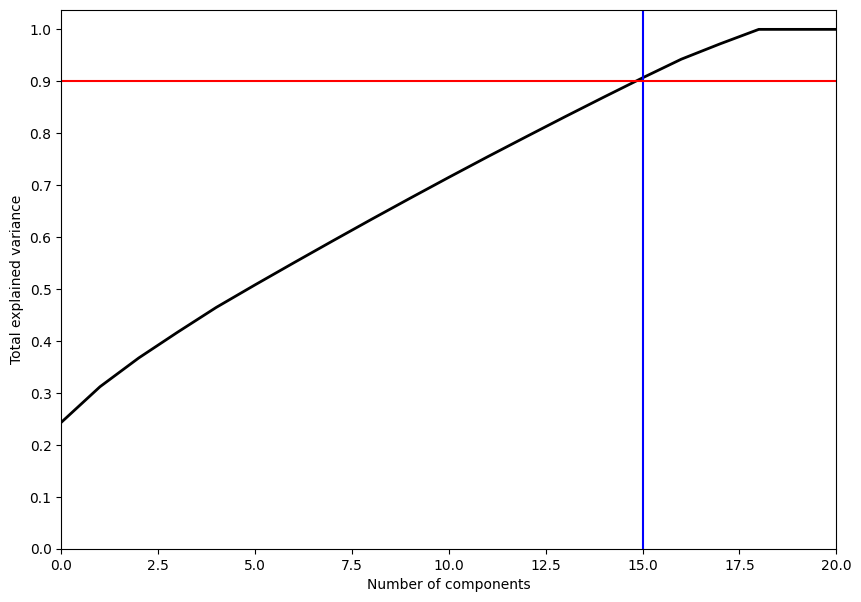

In [318]:
pca = decomposition.PCA().fit(scaled_data)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 20)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(15, c='b')
plt.axhline(0.9, c='r')
plt.show();

##### 3.3.2.2 Selection of optimal components and hyperparameters for DBSCAN

In [319]:
n_components_list = [5, 10, 15]
eps_list = np.linspace(0.1, 1.0, 10)
min_samples_list = [2, 5, 8, 11]
silhouette_scores = []
for n in n_components_list:
    pca_data = PCA(n_components=n).fit_transform(scaled_data)
    for eps, min_samp in itertools.product(eps_list, min_samples_list):
        model = DBSCAN(eps=eps, min_samples=min_samp).fit(pca_data)
        labels = model.labels_

        if len(set(labels)) > 1 and -1 in labels:
            score = silhouette_score(pca_data, labels)
            silhouette_scores.append((n, eps, min_samp, score))

In [320]:
df_silhouette = pd.DataFrame(silhouette_scores, columns=['n_components', 'eps', 'min_samples', 'silhouette_score'])

In [321]:
df_silhouette

,n_components,eps,min_samples,silhouette_score
0,5,0.1,2,-0.710144
1,5,0.1,5,-0.376709
2,5,0.2,2,-0.246759
3,5,0.2,5,-0.496965
4,5,0.2,8,-0.580433
5,5,0.2,11,-0.514628
6,5,0.3,2,-0.037420
7,5,0.3,5,0.249866
8,5,0.3,8,0.183239
9,5,0.3,11,0.067828


## 4.0 Modeling

### 4.1 Principal component analysis

In [322]:
pca = PCA(n_components=5)
df_reduced = pca.fit_transform(scaled_data)

### 4.2 DBSCAN and hierarchical clustering hyperparameters

In [323]:
var_eps = 0.6
var_samples = 2
var_method = 'complete'
var_metric = 'euclidean'
threshold = 4

### 4.3 DBSCAN and hierarchical clustering label generation

In [324]:
def label_generation(data, var_eps, var_samples, var_method, var_metric, threshold):
  ahc = linkage(data, method=var_method, metric=var_metric)
  ahc_labels = fcluster(ahc, t=threshold, criterion='distance')
  dbs_labels = DBSCAN(eps=var_eps, min_samples=var_samples).fit_predict(data)
  return ahc_labels, dbs_labels, ahc

In [325]:
ahc_labels, dbs_labels, ahc = label_generation(df_reduced, var_eps, var_samples, var_method, var_metric, threshold)

### 4.4 DBSCAN and hierarchical clustering plots

In [326]:
def cluster_plotting_with_biplot(data_2d, ahc_labels, dbs_labels, title, feature_names=None, loadings=None, arrow_scale=5):

    if loadings is None:
        raise ValueError("You must provide PCA loadings to plot feature arrows.")

    plt.figure(figsize=(12, 12))

    plt.subplot(2, 1, 1) # 1, 2, 1
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=dbs_labels, cmap='Set1', s=10)
    plt.title('DBSCAN Clustering')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    for i, (x, y) in enumerate(loadings[:, :2]):
        plt.arrow(0, 0, x * arrow_scale, y * arrow_scale, color='black', alpha=0.6,
                  width=0.01, head_width=0.1, length_includes_head=True)
        label = feature_names[i] if feature_names and i < len(feature_names) else f'Feature {i+1}'
        #plt.text(x * arrow_scale * 1.1, y * arrow_scale * 1.1, label, color='black', fontsize=9)

    plt.subplot(2, 1, 2) # 1, 2, 2
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=ahc_labels, cmap='Set1', s=10)
    plt.title('Hierarchical Clustering')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    for i, (x, y) in enumerate(loadings[:, :2]):
        plt.arrow(0, 0, x * arrow_scale, y * arrow_scale, color='black', alpha=0.6,
                  width=0.01, head_width=0.1, length_includes_head=True)
        label = feature_names[i] if feature_names and i < len(feature_names) else f'Feature {i+1}'
        #plt.text(x * arrow_scale * 1.1, y * arrow_scale * 1.1, label, color='black', fontsize=9)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

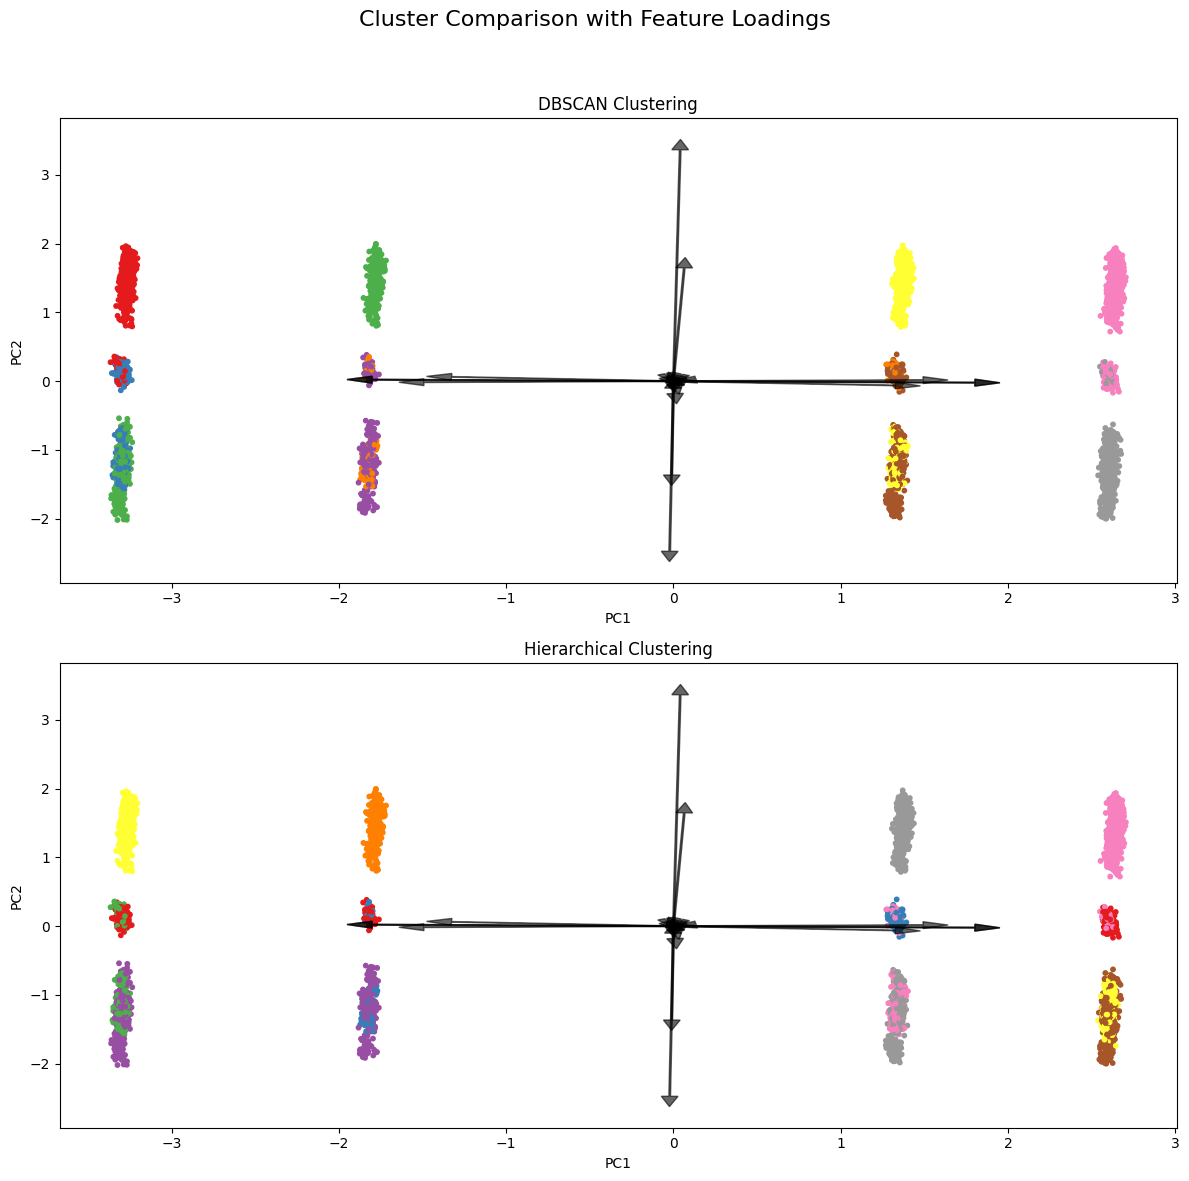

In [327]:
pca = PCA(n_components=2)
data_2d = pca.fit_transform(scaled_data)
loadings = pca.components_.T
feature_names = df_scaled.columns.tolist()

cluster_plotting_with_biplot(
    data_2d,
    ahc_labels,
    dbs_labels,
    "Cluster Comparison with Feature Loadings",
    feature_names=feature_names,
    loadings=loadings,
    arrow_scale=5
)

In [328]:
loadings = pca.components_.T  # shape: (n_features, n_components)
feature_names = df_scaled.columns.tolist()  # original feature names

factor_loadings = []
for i, feature in enumerate(feature_names):
    factor_loadings.append({
        "feature": feature,
        "PC1_loading": float(loadings[i, 0]),
        "PC2_loading": float(loadings[i, 1])
    })

# Display as a table
import pandas as pd
pd.DataFrame(factor_loadings)

,feature,PC1_loading,PC2_loading
0,Age,-0.002643,-0.019405
1,Purchase Amount (USD),0.008018,-0.011517
2,Review Rating,0.003644,-0.065973
3,Previous Purchases,-0.015330,0.003058
4,Gender_Female,0.295242,-0.013848
5,Gender_Male,-0.295242,0.013848
6,Subscription Status_No,0.328354,0.003289
7,Subscription Status_Yes,-0.328354,-0.003289
8,Discount Applied_No,0.390277,-0.004718
9,Discount Applied_Yes,-0.390277,0.004718


### 4.4 DBSCAN and hierarchical cluster value counts

In [329]:
print("DBSCAN cluster value counts:")
print(pd.Series(dbs_labels).value_counts())

DBSCAN cluster value counts:
 15    527
 0     418
 11    412
 17    392
 4     334
 14    305
 5     256
 7     209
 18    199
 2     171
 12    141
 16    101
 3      90
 8      87
 13     79
 6      53
 1      39
 10     38
 19     29
 9      18
-1       2
Name: count, dtype: int64


In [330]:
print("Hierarchical clustering cluster value counts:")
print(pd.Series(ahc_labels).value_counts())

Hierarchical clustering cluster value counts:
12    556
9     418
14    412
11    392
7     334
15    305
8     256
5     210
6     209
10    199
13    179
1     144
4     106
2     101
3      79
Name: count, dtype: int64


### 4.5 Hierarchical clustering dendrogram

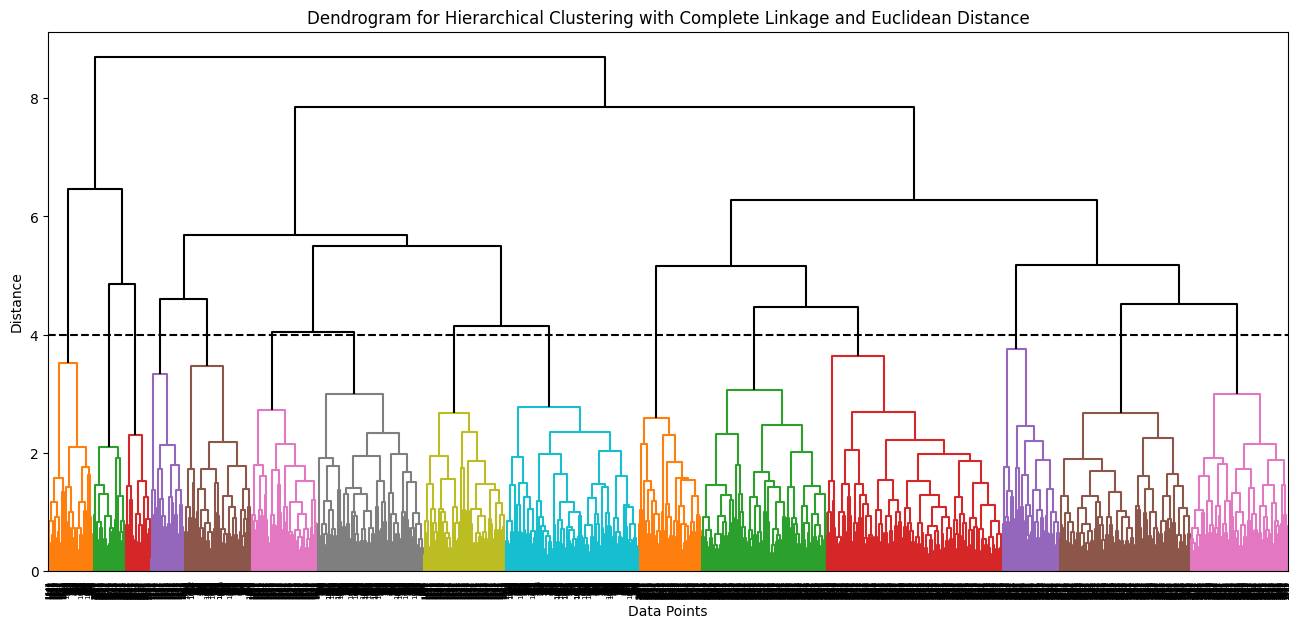

In [331]:
plt.figure(figsize=(16, 7))
dendrogram(ahc, color_threshold = 4, above_threshold_color='black')
plt.title('Dendrogram for Hierarchical Clustering with Complete Linkage and Euclidean Distance')
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.axhline(y=4, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.show()

## 5.0 Evaluation

### 5.1 DBSCAN evaluation

In [332]:
eps_list = np.linspace(0.1, 1.0, 10)
min_samples_list = [2, 5, 8, 11]

In [333]:
dbscan_summary = []

In [334]:
for eps, min_samp in itertools.product(eps_list, min_samples_list):
    model = DBSCAN(eps=eps, min_samples=min_samp).fit(df_reduced)
    labels = model.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 1:
        # Compute metrics
        sil_score = silhouette_score(df_reduced, labels)
        dbi_score = davies_bouldin_score(df_reduced, labels)

        # Append to unified summary
        dbscan_summary.append((eps, min_samp, n_clusters, sil_score, dbi_score))

# Create DataFrame
df_dbscan_summary = pd.DataFrame(dbscan_summary, columns=[
    'Epsilon', 'Minimum Samples', 'Clusters',
    'Silhouette Score', 'Davies–Bouldin Index'
])

In [335]:
df_dbscan_summary = pd.DataFrame(dbscan_summary, columns=[
    'Epsilon', 'Minimum Samples', 'Clusters',
    'Silhouette Score', 'Davies–Bouldin Index'
])
df_dbscan_summary

,Epsilon,Minimum Samples,Clusters,Silhouette Score,Davies–Bouldin Index
0,0.1,2,217,-0.710144,1.047995
1,0.1,5,2,-0.376709,1.031952
2,0.2,2,405,-0.246759,1.103480
3,0.2,5,84,-0.496965,1.136500
4,0.2,8,29,-0.580433,1.097847
5,0.2,11,12,-0.514628,1.057834
6,0.3,2,87,-0.037420,1.122879
7,0.3,5,35,0.249866,1.192973
8,0.3,8,29,0.183239,1.155200
9,0.3,11,28,0.067828,1.132596


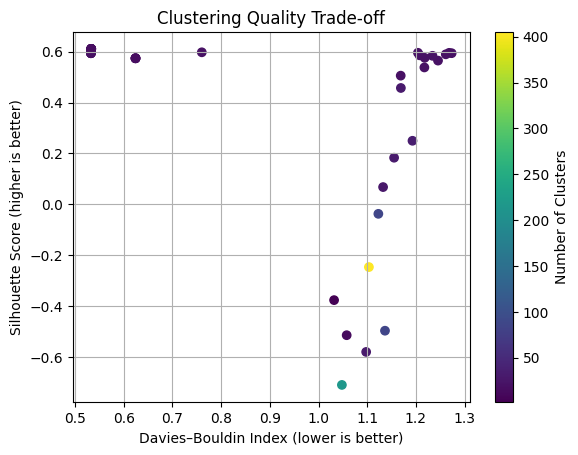

In [336]:
plt.scatter(df_dbscan_summary['Davies–Bouldin Index'], df_dbscan_summary['Silhouette Score'], c=df_dbscan_summary['Clusters'], cmap='viridis')
plt.xlabel('Davies–Bouldin Index (lower is better)')
plt.ylabel('Silhouette Score (higher is better)')
plt.title('Clustering Quality Trade-off')
plt.colorbar(label='Number of Clusters')
plt.grid(True)
plt.show()

### 5.2 Agglomerative hierarchical clustering evaluation

In [337]:
methods_list = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
metrics_list = ['euclidean', 'manhattan', 'cosine', 'correlation']
t_list = [4, 5, 6]

In [338]:
valid_combinations = {
    'single':     ['euclidean', 'cosine', 'correlation'],
    'complete':   ['euclidean', 'cosine', 'correlation'],
    'average':    ['euclidean', 'cosine', 'correlation'],
    'weighted':   ['euclidean', 'cosine', 'correlation'],
    'centroid':   ['euclidean'],
    'median':     ['euclidean'],
    'ward':       ['euclidean']
}

In [339]:
cluster_summary = []

In [340]:
for method in methods_list:
    for metric in valid_combinations[method]:
        try:
            linkage_matrix = linkage(df_reduced, method=method, metric=metric)
            for t in t_list:
                labels = fcluster(linkage_matrix, t=t, criterion='distance')
                n_clusters = len(set(labels))
                if n_clusters > 1:
                    sil_score = silhouette_score(df_reduced, labels)
                    dbi_score = davies_bouldin_score(df_reduced, labels)
                    cluster_summary.append((method, metric, t, n_clusters, sil_score, dbi_score))
        except Exception as e:
            print(f"Error with method={method}, metric={metric}, clusters={n_clusters}, t={t}: {e}")

In [341]:
df_csummary = pd.DataFrame(cluster_summary, columns=[
    'Method', 'Metric', 'Dendrogram Cut Threshold', 'Clusters',
    'Silhouette Score', 'Davies–Bouldin Index'
])
df_csummary

,Method,Metric,Dendrogram Cut Threshold,Clusters,Silhouette Score,Davies–Bouldin Index
0,complete,euclidean,4,15,0.609279,0.586393
1,complete,euclidean,5,9,0.466459,0.878995
2,complete,euclidean,6,5,0.359332,1.085350
3,average,euclidean,4,4,0.340087,0.992388
4,average,euclidean,5,2,0.442730,0.988250
5,weighted,euclidean,4,4,0.340087,0.992388
6,weighted,euclidean,5,2,0.442730,0.988250
7,centroid,euclidean,4,2,0.442730,0.988250
8,median,euclidean,4,2,0.442730,0.988250
9,ward,euclidean,4,70,0.242077,1.233070


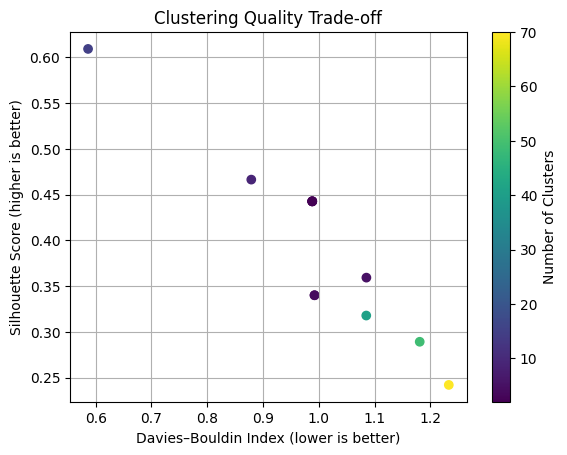

In [342]:
plt.scatter(df_csummary['Davies–Bouldin Index'], df_csummary['Silhouette Score'], c=df_csummary['Clusters'], cmap='viridis')
plt.xlabel('Davies–Bouldin Index (lower is better)')
plt.ylabel('Silhouette Score (higher is better)')
plt.title('Clustering Quality Trade-off')
plt.colorbar(label='Number of Clusters')
plt.grid(True)
plt.show()

## 6.0 Deployment

Paper: ComfortJDDS8536-5 - DBSCAN and Hierarchical Clustering Analysis of Customer Shopping Trends